# Proyecto

Objetivo: Analizar la seguridad de contraseñas con base en la lista de contraseñas y su frecuencia de uso

- Los problemas de clasificación predicen una lista ordenada o una clasificación de objetos, la manera en el que se realizó la consulta. Esto podría ser bastante práctico si lo que queremos es regresar la lista de contraseñas que alguien podría colocar al momento de ingresar su contraseña. 
- La clasificación predice una etiqueta y los problemas incluyen problemas binarios de "sí o no" como "si esta imagen es un corgi o un muffin de arándanos", así como problemas de clasificación múltiple como "si esto es bueno, malo o promedio". Con la clasificación, las respuestas correctas deben etiquetarse para que su algoritmo pueda aprender de ellas.
- Exactamente, que es lo que deseamos encontrar?
- Que tipo de visualizaciones se elige?

Fuente de la información:
1. Bruteforce Database Github
2. https://github.com/duyet/bruteforce-database
3. https://haveibeenpwned.com/Passwords **Pwned Passwords 20 GB.**
4. https://www.kaggle.com/search?q=passwords
5. https://github.com/robinske/password-data

Primero haremos una exploración de los datos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import random
from torch.multiprocessing import Process, Queue, Lock
import multiprocessing as mp

In [2]:
data =pd.read_csv('passwords/pass (1).csv')
for i in range(2,100):
    filename = pd.read_csv('passwords/pass ('+str(i)+').csv')
    data = pd.concat([data,filename],axis=0)
data

,password,hash,count
0,1980290,083040BB6B1D95F2B8AC447B50D21DAB38DAFF16,13
1,tornadof,0A7709AD9837766F20156FF016ABF66F8036ABC1,13
2,vova87654,66221A7691CDC27D9D31071A0CFA0712C100C7D7,13
3,XpKvShrO,4CB7086C94AE4D82E519FF8F98D0DA1DA38DBE53,13
4,tvjgtl,9E1FD26A17D2EBE7C9FD4181EF49424C7091D484,13
...,...,...,...
6840,491144,4511C39CDA1EFE76964C79783B52053BA7CD09DD,69
6841,xeyfhm3477362341,E2EC663D721E9F22F5CF39D5AA27A89CE00172D0,69
6842,irontree4,350AA827594B47AF3BCB9256E2388EFB958C4529,69
6843,wh2t3v3r,221C76F1C2AD5883003AF5EB7A495A41580B87C5,69


## Perfilado de Datos

Para esto, vamos a ver algunas características de los datos, como sus valores nulos y duplicados.

In [3]:
data.isnull().sum()

password    2
hash        0
count       0
dtype: int64

In [4]:
data = data.dropna(axis=0)
data.isnull().sum()

password    0
hash        0
count       0
dtype: int64

Ahora, existen valores duplicados en cada documento, que son el conteo de contraseñas segmentado, por lo cual será adecuado sumar las cuentas de todos los duplicados
para obtener el número de veces que cada contraseña fue usada.

Adicionalmente, en este momento no haremos usos de las firmas hash, puesto que no son relevantes para nuestro caso de estudio

In [5]:
data = data.groupby(data['password']).agg({'count':sum}).reset_index()
print(data.shape)
data.head()

(677566, 2)


,password,count
0,!!!!!,401
1,!!!!!!,2304
2,!!!!!!!,386
3,!12345,312
4,!23456,347


## Exploración de los datos:

Veamos algunas de las contraseñas más utilizadas

In [6]:
data = data.sort_values(by='count',ascending=False)
data.head()

,password,count
43879,123456789,7016669
506981,qwerty,3599486
35227,111111,2900049
43856,12345678,2680521
223879,abc123,2670319


La cuenta de aquellas contraseñas que tienen únicamente valores numéricos:

In [7]:
# Variable que guardará el total de contraseñas con esta característica y las veces que fueron utilizadas
data_patrones = []

numeric = data[data['password'].str.isnumeric() == True].count()[0]
numeric_count_sum = data[data['password'].str.isnumeric() == True]['count'].sum()

print('Contraseñas formadas por números:')
print(numeric)
print('Suma del uso de contraseñas formadas por números')
print(numeric_count_sum)

data_patrones += 'Numeric only', numeric, numeric_count_sum

Contraseñas formadas por números:
142340
Suma del uso de contraseñas formadas por números
171260703


In [8]:
alpha = data[data['password'].str.isalpha() == True].count()[0]
alpha_count_sum = data[data['password'].str.isalpha() == True]['count'].sum()

print('Contraseñas formadas por letras:')
print(alpha)
print('Suma del uso de contraseñas formadas por letras')
print(alpha_count_sum)

data_patrones += 'Alpha only', alpha, alpha_count_sum

Contraseñas formadas por letras:
278189
Suma del uso de contraseñas formadas por letras
335503274


---
A continuación consideraremos que una contraseña corta es aquella con menos de 8 carácteres:

In [9]:
short_pass = data[data['password'].str.len() < 8].count()[0]
short_pass_count_sum = data[data['password'].str.len() < 8]['count'].sum()

print('Contraseñas cortas:')
print(short_pass)
print('Suma del uso de contraseñas cortas')
print(short_pass_count_sum)

data_patrones += 'Short Passwords', short_pass, short_pass_count_sum

Contraseñas cortas:
382452
Suma del uso de contraseñas cortas
477964360


---
Y analizamos aquellas que tienen carácteres poco comunes o poco usados, como guiones, signos de exclamación, etc.

In [10]:
special_chars = ['!','"','#','<','>','%','&','/','=',
                '(\?)','(\()','(\))',"'",'¡','¿','(\+)','~',']','}',
                '(\[)','{',',',';',':','(\.)','_','-','(\*)','(\^)']

special_chars = '|'.join(special_chars)
special_pass = data[data['password'].str.contains(special_chars) == True].count()[0]
special_pass_count_sum = data[data['password'].str.contains(special_chars) == True]['count'].sum()

print('Contraseñas cortas:')
print(special_pass)
print('Suma del uso de contraseñas cortas')
print(special_pass_count_sum)

data_patrones += 'Special Characters', special_pass, special_pass_count_sum

/home/oswald/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Contraseñas cortas:
2147
Suma del uso de contraseñas cortas
1977061


Siguientes pasos:
- Análisis de las frecuencias
- Generar métrica para el score para las contraseñas de acuerdo a su frecuencia
- Red neuronal Recurrente (?) para evaluar seguridad de una contraseña entrenada con las scores del punto anterior
- Hacer análisis mediante k-neighbors o kohonen para comparar
- Proponer contraseñas seguras (por definir método)

Ahora vamos a establecer una métrica para pasar de la cuenta de las contraseñas a una métrica de su seguridad, para esto se decide hacer un escalamiento estándar al inverso de la cuenta de contraseñas. Esto para darle una mayor scoring a aquellos que tienen menos apariciones.

In [11]:
from copy import copy

pass_count = data.iloc[:,1].values
pass_count = 1/pass_count
passes = copy(data.iloc[:,0].values.tolist())
#print(passes)

max_len_pass = 0 # Vamos guardando la longitud de contraseña más grande
min_string = 1000 # Guardamos el ASCII más pequeño que nos encontramos

for i in range(len(passes)):
    passes[i] = list(map(ord,list(passes[i])))
    if len(passes[i]) > max_len_pass:
        max_len_pass = len(passes[i])
    
    for letter_ascii in passes[i]:
        if letter_ascii < min_string:
            min_string = letter_ascii

min_string -= 1 # min_string será el valor para el espacio vacío

for i in range(len(passes)):
    n = len(passes[i])
    passes[i] = passes[i] + [min_string]*(max_len_pass-len(passes[i]))
    
    
passes = np.array(passes)
passes.shape

(677566, 27)

In [12]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
passes_std = ms.fit_transform(passes.reshape(-1,27))

def password_to_encode(password):
    '''
    Función que dada una contraseña, devuelve el encoding acomodado al tratamiento
    que tuvieron los datos de este documento.
    --------------------------------------------------------------
    :param password str: Cadena de texto que contiene la contraseña a convertir
    
    :returns array: Vector 27-dimensional codificado. 
    '''
    pass_vector = list(map(ord,list(password)))
    pass_vector += [min_string]*(max_len_pass-len(pass_vector))
    pass_vector = np.array(pass_vector)
    pass_vector = ms.transform(pass_vector.reshape(-1,27))
    
    return pass_vector
    
password_to_encode(data.iloc[:,0].values[0]) == passes_std[0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [13]:
from sklearn.preprocessing import MinMaxScaler    
    

sc = MinMaxScaler()
pass_count_std = sc.fit_transform(pass_count.reshape(-1,1))
pass_count_std = pass_count_std.reshape(-1)

Ahora procederemos a hacer el intervalo que abarca el escalamiento, dividiendo en 50 bloques

In [14]:
minimo = min(pass_count_std)
maximo = max(pass_count_std)
intervalo = np.linspace(minimo,maximo)

Enseguida, se asigna una puntuación a las contraseñas en función a su posicionamiento en el escalamiento, siendo aquellos que se encuentran en la cola inferior, los que tienen peor seguridad, mientras los que estén en la cola superior, tendrán un score de 49, la máxima seguridad.

In [15]:
pass_security = np.zeros(len(pass_count_std))
intervalo_idx = 0
for i in range(len(pass_count_std)):
    while( intervalo[intervalo_idx] < pass_count_std[i]):
        intervalo_idx += 1
    pass_security[i] = intervalo_idx
pass_security = pass_security.astype(int)

In [16]:
print(passes.shape)

(677566, 27)


In [17]:
passwords = pd.DataFrame({'Password':data.iloc[:,0],'Security':pass_security})
passwords

,Password,Security
43879,123456789,0
506981,qwerty,1
35227,111111,1
43856,12345678,1
223879,abc123,1
...,...,...
657154,yzx2095,49
164115,80931194654,49
607352,wallygoo,49
387486,jackpudes1,49


Dividimos en set de entrenamiento y validación

In [18]:

from sklearn.preprocessing import OneHotEncoder

pass_security = pass_security.reshape(-1,1)
ohe = OneHotEncoder()
pass_security = ohe.fit_transform(pass_security).toarray()

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(passes_std, pass_security, test_size=0.2)

In [20]:
X = passes_std
Y = pass_security

In [21]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
class Gen_net(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos 
    evaluar el algoritmo genético.
    '''
    def __init__(self, in_features, hidden1, hidden2, out_features):
        '''
        Estructura de la red neuronal a utilizar.
        -----------------------------------------
        :param in_features int: Neuronas de entrada
        :param hidden1 int: Neuronas en la primer capa oculta
        :param hidden2 int: Neuronas en la segunda capa oculta
        :param out_features: Neuronas de salida
        '''
        super(Gen_net,self).__init__()
        
        self.fc1 = nn.Linear(in_features = in_features, out_features = hidden1,bias = False)
        self.fc2 = nn.Linear(in_features = hidden1, out_features = hidden2,bias = False)
        self.fc3 = nn.Linear(in_features = hidden2, out_features= out_features,bias = False)
        
        self.in_features = in_features
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.out_features = out_features
        

        
        
    def forward(self, X):
        '''
        Función feed-forward con activación sigmoide entre capas.
        ---------------------------------------------------------
        :param X [float]: Vector o matriz de neuronas de entrada .
        
        :returns [float]: Activaciones de la red en la última capa.
        '''
        capa_oculta1 = torch.sigmoid(self.fc1(X))
        capa_oculta2 = torch.sigmoid(self.fc2(capa_oculta1))
        salida = torch.sigmoid(self.fc3(capa_oculta2))
        
        return salida


    def back_propagate(self, X, Y):
        '''
        Función que hace un paso de backpropagation con la entrada X con salida correcta Y,
        Como la función de activación sigmoide ronda entre valores del 0 y 1, esta nunca los
        va a tocar, es por ello que consideramos un truncamiento en los valores 0.2,0.8 de tal
        manera que aquellos valores antes del primero, no se activarán (0) y después del segundo, 
        se activarán (1). Utiliza función de error cuadrada.
        -----------------------------------------------------------------------
        :param X [float]: Matriz o Vector de neuronas de entrada
        :param Y [float]: Matriz o Vector a predecir con la entrada X
        
        :returns [float]: Error de gradiente
        '''
        salida = self.forward(X)
        funcion_error = nn.MSELoss()
        
        error = funcion_error(torch.clamp(salida,0.2,0.8),
                               torch.clamp(Y,0.2,0.8))
                    
        error.backward()
        
        return error
        
    def train(self, train_X, train_Y, optimizer, ciclos=100):
        '''
        Función de entrenamiento para la red, la cual utiliza al conjunto
        de entrenamiento y la función de error definida en la función
        back_propagate(). Al finalizar, muestra una gráfica del error
        ------------------------------------------------------------
        :param train_X [float]: Datos de entrenamiento
        :param train_Y [float]: Etiquetas correspondientes a los datos
                                de entrenamiento.
        :param optimizar torch.optim: Algoritmo de optimización
        :ciclos int: Número de épocas de entrenamiento
        
        '''
        self.optimizer = optimizer
        criterio = torch.nn.MSELoss()
        errores = np.zeros(ciclos)
        
        for ciclo in range(ciclos):
            y_pred = self.forward(train_X)
            perdida = criterio(torch.clamp(y_pred,0.2,0.8),
                               torch.clamp(train_Y,0.2,0.8))
            errores[ciclo] = perdida.item()
            
            self.optimizer.zero_grad()
            self.back_propagate(train_X,train_Y)
            self.optimizer.step()
            
        if ciclos > 1:
            pasos = np.arange(ciclos)
            plt.plot(pasos, errores, label='Entrenamiento')

    def confusion(self, test_X, test_Y):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        
        y_pred = self.forward(test_X)
        #print(y_pred[:20])
        labels = []
        for salida in y_pred:
            label = []
            max_idx = max(salida)
            
            for i in range(7):
                if salida[i] == max_idx:
                    label.append(1.)
                else:
                    label.append(0.)
            labels.append(label)

        VP = 0
        VN = 0
        FP = 0
        FN = 0
        
        for i in range(len(test_Y)):

            if all(torch.tensor(labels[i])==test_Y[i]):
                VP += 1
                VN += 6
            else:
                FP += 1
                FN += 1
                VN += 5
            
        print(
        """
    VP ={:.<5}    FN={:.<5}
    FP ={:.<5}    VN={:.<5}
    
            """.format(VP,FN,FP,VN)) 
        

In [24]:
import copy
class Gen_train():
    '''
    Algoritmo genético 
    '''

    def __init__(self, model, parent_scalar, operator_probabilities, population_size):
        '''
        Propiedades del algoritmo genético 
        -----------------------------------------
        :param model nn.net: Red Neuronal sobre el que se aplicará el algoritmo
        :param parent_scalar float: Parámetro que determina en la cruza, con qué
                        probabilidad se escoje a los padres de un cromosoma:
                        El mejor cromosoma tiene parent_scalar probabilidades de ser 
                        escogido como padre, si no, el segundo padre tiene parent_scalar
                        probabilidad de ser escogido como padre y así hasta que encuentre 2 padres.
        :param operator_probabilities [float]: Probabilidad de cada operador de ser utilizado.
        :param population_size int: Población inicial elegida al azar utilizando una distribución t. 
        '''
        self.model = model
        self.parent_scalar = parent_scalar
        self.operator_probabilities = operator_probabilities
        self.population_size = population_size

        # Elementos de la población
        self.elements = []

        # Forma de las matrices de peso
        self.vector_size = []

        # Capas ocultas de la red:
        i = 0
        for param in self.model.parameters():
            i += 1
            self.vector_size.append(param.size())

        self.layers = i

        for i in range(self.population_size):
            chromosome = []
            
            for j in range(len(self.vector_size)):
                layer = self.vector_size[j]
                layer_size = layer[0]*layer[1]
                # print(layer_size)
                chromosome += random.standard_t(1, layer_size).tolist()
                
            self.elements.append(chromosome)
        
        self.elements = torch.tensor(self.elements)

    def get_weights(self, element, elementos_lista):
        '''
        Función para obtener las matrices de pesos a partir de 
        un elemento de la población.
        Tiene las mismas dimenciónes que los pesos para la red.
        -------------------------------------------------------
        :param element int: Número de elemento de la lista elementos_lista
        :param elementos_lista [[float]]: Lista de cromosomas
        
        :returns M1, M2, M3 np.ndarray: Matrices correspondientes a cada capa
                                    usando el vector de parámetro dado. 
        '''
        
        sample = elementos_lista[element]
        Matrices = []
        idx = 0

        for layer_idx in range(self.layers):

            matriz_size = self.vector_size[layer_idx]
            matriz = np.array(sample[idx:idx+(matriz_size[0]*matriz_size[1])])
            matriz.resize(matriz_size)
            matriz = torch.tensor(matriz)
            Matrices.append(matriz)
            idx += matriz_size[0]*matriz_size[1]

        return Matrices[0], Matrices[1], Matrices[2]
    

    def set_chromosome(self, w1, w2, w3, element):
        '''
        Función que dadas tres matrices que determinan los pesos de la red,
        actualiza un elemento de la lista de cromosomas como vector de parámetro
        generado por dichas matrices.
        -------------------------------------------------------------------
        :param w1 [[float]]: Pesos de la primera capa
        :param w2 [[float]]: Pesos de la segunda capa
        :param w3 [[float]]: Pesos de la última capa
        :param element int: Elemento de la población a actualizar
        '''
        sample = []
        matrices = [w1,w2,w3]
        matrices_aux = matrices.copy()
        
        for i in range(len(matrices)):
            matrices_aux[i].resize_([1,matrices[i].size()[0]
                                     *matrices[i].size()[1]])
            #print(matrices_aux[i].tolist())
            sample += matrices_aux[i].tolist()[0]
        #print(sample)
        
        self.elements[element] = torch.tensor(sample)

    def fitness(self, X, Y, element, elementos_lista):
        '''
        Función que evalúa a un cromosoma según su desempeño y qué tan bien
        acierta en predicción. Entre menor puntaje, menor error, por lo
        cual será un cromosoma más apto y tendrá mas probabilidad de
        reproducirse.
        --------------------------------------------
        :param X [float]: Matriz o Vector de neuronas de entrada
        :param Y [float]: Matriz o Vector a predecir con la entrada X     
        :param element int: Número de elemento de la lista elementos_lista
        :param elementos_lista [[float]]: Lista de cromosomas
        
        returns float: Puntaje del cromosoma
        '''
        capa1 = self.model.fc1
        capa2 = self.model.fc2
        capa3 = self.model.fc3
        
        pesos = self.get_weights(element,elementos_lista)
        
        w1 = pesos[0]
        w2 = pesos[1]
        w3 = pesos[2]
        #print('hola')
        
        with torch.no_grad():
            capa1.weight = nn.Parameter(w1)
            capa2.weight = nn.Parameter(w2)
            capa3.weight = nn.Parameter(w3)
        #print(capa1)
        #print(self.model.fc1)
        salida = self.model.forward(X)
        loss = nn.MSELoss()
        output = loss(salida, Y)
        
        return output

    # Define las operaciónes que se usan en el experimento número 5 del artículo.
    # Todas las definiciones de los operadores se encuentrán en la sección 5 del
    # artículo.
    
    
    def get_nodo(self,nodo,elemento):
        '''
        Función que dado un nodo (neurona), junto al número de elemento de la lista de
        cromosomas, regresa el inicio y fin de aquellos indices del cromosoma que
        corresponden a los pesos entrantes a esa neurona.
        ---------------------------------------------------------------------
        :param nodo int: Número que indica la neurona sobre la que se quiere
                        extraer los indices de sus pesos entrantes dentro del
                        cromosoma.
        :param elemento int: Índice del elemento de la lista de cromosomas del
                            objeto.
        :returns inicio, fin [int]: Listas en donde cada entrada j, representa el
                                    inicio y fin (respectivamente) de el peso 
                                    entrante j a la neurona.
        '''
        
        neuronas = self.model.hidden1+self.model.hidden2+self.model.out_features
        nodo_a_cambiar = 0
        capa = 0
        # puntero del lugar del nodo a cambiar
        idx = 0
        #iteración sobre los nodos de la capa actual
        idx_nodo = 0

        while(True):
            
            if nodo == nodo_a_cambiar:
                break
                
            nodo_a_cambiar +=1
            idx += self.vector_size[capa][1]            
            idx_nodo += 1
            
            if idx_nodo%self.vector_size[capa][0] == 0 and capa<2:
                capa +=1
                idx_nodo=0
        
        
        inicio = idx
        #print(inicio, idx + self.vector_size[capa][0]+1)
        fin = (idx + self.vector_size[capa][1])%len(self.elements[0])
        
        return inicio, fin
    
    
    
    def mutacion(self,n,elemento,elementos_lista, seed = 100):
        '''
        Función que mutará n nodos(pesos entrantes a una neurona) de un elemento
        de la lista de cromosomas.
        
        '''
        #entero aleatorio entre neuronas
        neuronas = self.model.hidden1+self.model.hidden2+self.model.out_features
        rn = np.random.RandomState(seed + np.random.randint(1,100))
        random_nodes = rn.choice(range(neuronas),n,replace=False)
        #print(random_nodes)

        for nodo in random_nodes:
            

            inicio, fin =self.get_nodo(nodo,elemento)
            #print(inicio,fin)
            if nodo == neuronas-1:
                row = elementos_lista[elemento][inicio:]
            else:
                row = elementos_lista[elemento][inicio:fin]
            #print(row)
            for param in row:
                if (rn.random(1)[0]<1):
                    param += float(random.normal(size=1))
            
        
    def cross(self,parent1,parent2,elementos_lista, seed = 100):
        '''
        Función que representa la cruza entre dos cromosomas donde la
        elección de parámetros que heredará será aleatoria.
        ------------------------------------------------------
        :param parent 1 int: Índice dentro de la lista de elementos
                            que representa la posición del primer 
                            padre.
        :param parent 2 int: Índice dentro de la lista de elementos
                            que representa la posición del segundo 
                            padre.
        :param elementos_lista [[float]]: Lista de cromosomas
        
        :returns child torch.tensor: Cromosoma hijo
        '''
        
        neuronas = self.model.hidden1+self.model.hidden2+self.model.out_features
        rn = np.random.RandomState(seed + np.random.randint(1,100))
        n = rn.randint(0,neuronas)
        # Lista de nodos que se heredarán del familiar1
        random_nodes = np.random.choice(range(neuronas),n)
        
        child = []
        
        for i in range(neuronas):
            
            
            if i in random_nodes:
                inicio, fin =self.get_nodo(i,parent1)
                #print(inicio,fin)
                row = elementos_lista[parent1][inicio:fin]
                child += row.tolist()
            else:
                inicio, fin =self.get_nodo(i,parent2)
                #print(inicio,fin)
                row = elementos_lista[parent2][inicio:fin]
                child += row.tolist()
                
        if neuronas-1 in random_nodes:
            inicio, fin =self.get_nodo(neuronas-1,parent1)
            row = elementos_lista[parent1][inicio:]
        else:
            inicio, fin =self.get_nodo(neuronas-1,parent2)
            row = elementos_lista[parent2][inicio:]
            child += row.tolist()
        
        return torch.tensor(child)
                
    def iteracion_entrenamiento(self, idx, step, seed, elems_copy,new_gen_queue,p_cross,best_scores):
        '''
        Código del hijo
        '''
        rn =np.random.RandomState(((idx+seed)**(step+1)+7)%(2**32-1))
        semilla = ((idx**2 + seed**7) + rn.randint(1,100))%(2**32-1)
        rand_int = rn.random(1)[0]

        if rand_int < self.operator_probabilities: #mutamos

            parent_idx = rn.randint(0,self.population_size-1)
            self.mutacion(2,parent_idx,elems_copy,semilla)
            child = elems_copy[parent_idx]
            #print(child)
            new_gen_queue.put(child)

        else: #Cruzamos
            parent_idx = 0
            parent2_idx = 0

            while(parent_idx < self.population_size):
                rand_int = rn.random(1)[0]
                if rand_int < p_cross:
                    break
                parent_idx +=1


            while(parent2_idx<self.population_size):
                rand_int = rn.random(1)[0]
                if (rand_int < p_cross) and (parent2_idx != parent_idx):
                    break
                parent2_idx +=1

            child = self.cross(best_scores[parent_idx],best_scores[parent2_idx],elems_copy,semilla)
            #print(child)
            new_gen_queue.put(child)   
            
    def train_concurrente(self,X, y, steps=50,seed=100, update=False, in_place=True):
        '''
        Entrenamiento usando concurrencia.
        Experimentalmente usar alrededor de 10 procesos
        '''
        elems_copy = self.elements.clone()
        errors = []
        for pasos in range(steps):
            
            #print('\n',elems_copy)
            best_scores = sorted(range(len(elems_copy)), key= lambda x: self.fitness(X,y,x,elems_copy))
            best = best_scores[0]
            if pasos%10 == 1:
                errors.append(self.fitness(X,y,best,elems_copy))
                if update:
                    print(f'Paso {pasos}, errores: {errors[-1]}, peor score:{self.fitness(X,y,best_scores[-1],elems_copy)}')
            p_cross = self.parent_scalar
            
            procesos = []
            #mutex = Lock()
            new_gen_queue = mp.Manager().Queue()
            
            # Concurrencia debe suceder aquí
            for i in range(0,self.population_size):
                proceso = Process(target=self.iteracion_entrenamiento, 
                                  args=(i, pasos, seed, elems_copy,new_gen_queue,p_cross,best_scores))
                procesos.append(proceso)
            for proceso in procesos:
                proceso.start()
            
            new_gen = []
            
            for proceso in procesos:
                proceso.join()
            
            while new_gen_queue.empty() is False:
                elem = new_gen_queue.get()
                new_gen.append(elem)
                #print(elem)
                
            #print(elems_copy[0])
            elems_copy = new_gen
            #print(elems_copy[0])
            
            
        if update: 
            plt.plot(errors)
        new_elems = torch.zeros(len(self.elements),len(self.elements[0]))
        
        #for i in range(len(self.elements)):
        #    new_elems[i] = elems_copy[i]
        
        if in_place:
            self.elements = new_elems
        return  new_elems
        
        
    def train(self, X, y, steps=50):
        '''
        Función de entrenamiento. Realiza el número de pasos seleccionados y grafica el 
        error de entrenamiento.
        
        Define la función de entrenamiento, la cuál se realizará el número de pasos 
        seleccionados. Usa la variable de parent_scalar para determinar la probabilidad 
        de que un individuo de la población sea remplazado en cada iteración. Muestra 
        una gráfica del error al finalizar el entrenamiento. Y regresa una red con
        los pesos del individuo con mejor fitness al finalizar el entrenamiento.
        '''
        elems_copy = self.elements.clone()
        
        errors = []
        
        for pasos in range(steps):
            
            new_gen =[]
            
            best_scores = sorted(range(len(elems_copy)), key= lambda x: self.fitness(X,y,x,elems_copy))
            best = best_scores[0]
            
            
            if pasos%10 == 1:
                errors.append(self.fitness(X,y,best,elems_copy))
                print(f'Paso {pasos}, errores: {errors[-1]}, peor score:{self.fitness(X,y,best_scores[-1],elems_copy)}')
                
                #print(parent2_idx)
            
            p_cross = self.parent_scalar
            
            
            
            # Concurrencia debe suceder aquí
            for i in range(1,self.population_size):
                rand_int = np.random.sample()
                
                if rand_int < self.operator_probabilities: #mutamos
                    
                    parent_idx = np.random.randint(0,self.population_size-1)
                    #print(parent_idx)
                    self.mutacion(2,parent_idx,elems_copy)
                    child = elems_copy[parent_idx]
                    new_gen.append(child)
                    
                    
                else: #Cruzamos
                    parent_idx = 0
                    parent2_idx = 0
                    
                    while(parent_idx < self.population_size):
                        rand_int = np.random.sample()
                        if rand_int < p_cross:
                            break
                        parent_idx +=1
                    
                    
                    while(parent2_idx<self.population_size):
                        rand_int = np.random.sample()
                        if (rand_int < p_cross) and (parent2_idx != parent_idx):
                            break
                        parent2_idx +=1
                        
                    child = self.cross(best_scores[parent_idx],best_scores[parent2_idx],elems_copy)
                    new_gen.append(child)
        
        
            
        
            elems_copy = new_gen
            
        plt.plot(errors)
        self.elements = elems_copy
        
    def confusion(self, test_X, test_Y):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        capa1 = self.model.fc1
        capa2 = self.model.fc2        
        capa3 = self.model.fc3
        best_scores = sorted(range(len(self.elements)), key= lambda x: self.fitness(test_X,test_Y,x,self.elements))
        element = best_scores[0]
        pesos = self.get_weights(element,self.elements)

        w1 = pesos[0]
        w2 = pesos[1]
        w3 = pesos[2]
        #print('hola')

        with torch.no_grad():
            capa1.weight = nn.Parameter(w1)
            capa2.weight = nn.Parameter(w2)
            capa3.weight = nn.Parameter(w3)


        y_pred = self.model.forward(test_X)
        #print(y_pred[:20])
        
        labels = []
        for salida in y_pred:
            label = []
            max_idx = max(salida)

            for i in range(7):
                if salida[i] == max_idx:
                    label.append(1.)
                else:
                    label.append(0.)
            labels.append(label)

        VP = 0
        VN = 0
        FP = 0
        FN = 0

        for i in range(len(test_Y)):

            if all(torch.tensor(labels[i])==test_Y[i]):
                VP += 1
                VN += 6
            else:
                FP += 1
                FN += 1
                VN += 5

        print(
        """
    VP ={:.<5}    FN={:.<5}
    FP ={:.<5}    VN={:.<5}

            """.format(VP,FN,FP,VN)) 
        

In [25]:
X.shape

(677566, 27)

In [26]:
Y.shape

(677566, 38)

In [27]:
Pass_net = Gen_net(27,30,40,38)

In [28]:
y_train = torch.tensor(y_train).type(torch.float)
X_train = torch.tensor(X_train).type(torch.float)
optimizer = optim.SGD(Pass_net.parameters(), lr=0.2, momentum=0.01)
#Pass_net.train(X_train,y_train,optimizer,ciclos=10)

In [29]:
Pass_gen = Gen_train(Pass_net, 0.92, 0.3, 10)

Paso 1, errores: 0.39011940360069275, peor score:0.637937068939209
Paso 11, errores: 0.33255887031555176, peor score:0.3569916784763336
Paso 21, errores: 0.29901930689811707, peor score:0.32852303981781006
Paso 31, errores: 0.2826368510723114, peor score:0.28473004698753357
Paso 41, errores: 0.27835381031036377, peor score:0.29203930497169495
Paso 51, errores: 0.27599939703941345, peor score:0.2772599458694458
Paso 61, errores: 0.2637977600097656, peor score:0.2867690920829773
Paso 71, errores: 0.25910794734954834, peor score:0.28992247581481934
Paso 81, errores: 0.25872474908828735, peor score:0.2716140151023865
Paso 91, errores: 0.257782518863678, peor score:0.25955137610435486
Paso 101, errores: 0.2461000680923462, peor score:0.2522173821926117
Paso 111, errores: 0.24010606110095978, peor score:0.263488233089447
Paso 121, errores: 0.22992826998233795, peor score:0.2497580498456955
Paso 131, errores: 0.2275967299938202, peor score:0.24407324194908142
Paso 141, errores: 0.226318329572

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

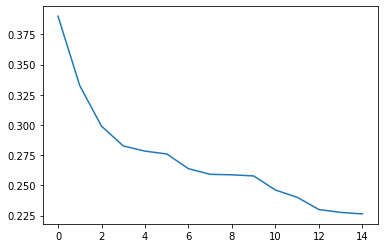

In [30]:
Pass_gen.fitness(X_train,y_train,5,Pass_gen.elements)
Pass_gen.train_concurrente(X_train[:500],y_train[:500],150,update=True,in_place=True)
#print(Pass_gen.elements)

In [31]:
def mix(A,B):
    shuf = np.random.choice(len(A), len(A), replace=False)
    A = sorted(zip(shuf,A), key=lambda x:x[0])
    B = sorted(zip(shuf,B), key=lambda x:x[0])
    
    return list(zip(*A))[1], list(zip(*B))[1]

def entrenar_batch(model,X,y,mini,maxi,steps_in_batch,mutex):
    print('Empezado')
    #cromosoma = model.train_concurrente(X[mini:maxi],y[mini:maxi], steps_in_batch,update=False,in_place=False)
    cromosoma = model.train(X[mini:maxi],y[mini:maxi], steps_in_batch)
    print('Aquí')
    mutex.acquire()
    cromosoma_lista.append(cromosoma)
    mutex.release()
    print('Acá')

def mini_batch_train(model, X,y,steps=100,steps_in_batch=10,n=500):
    cromosoma_actual = Pass_gen.elements
    
    intervalos = [0]
    i=n
    while(i<len(X)):
        intervalos.append(i)
        i += n
    intervalos.append(None)
    errors = []
    for i in range(steps):
        
        best_scores = sorted(range(len(cromosoma_actual)), 
                             key= lambda x: model.fitness(X,y,x,cromosoma_actual))
        best = best_scores[0]       
        
        if steps%10 == 1:
            errors.append(self.fitness(X,y,best,elems_copy))
            print(f'Paso {pasos}, errores: {errors[-1]}, peor score:{self.fitness(X,y,best_scores[-1],elems_copy)}')
        print(X)
        X,y = mix(X,y)
        new_elems1 = torch.zeros(len(X),len(X))
        new_elems2 = torch.zeros(len(y),len(y))
        for i in range(len(self.elements)):
            new_elems1[i] = X[i]
            new_elems2[i] = y[i]
        X,y = new_elems1, new_elems2
        cromosoma_lista = []
        
        for mini in range(len(intervalos)-1):
            inicio = intervalos[mini]
            fin = intervalos[mini+1]
            new_genes = model.train_concurrente(X[inicio:fin],y[inicio:fin], steps_in_batch,update=False,in_place=False)
            cromosoma_lista.append(new_genes)
        
        new_gen =  sum(cromosoma_lista)/len(cromosoma_lista)
        Pass_gen.elements = new_gen
    
    plt.plot(errors)
    
#mini_batch_train(Pass_gen, X_train, y_train,steps_in_batch=5,n=5000)

Paso 1, errores: 0.25, peor score:0.25
Paso 11, errores: 0.22460222244262695, peor score:0.24245405197143555
Paso 21, errores: 0.2154916673898697, peor score:0.2182053029537201
Paso 31, errores: 0.20201365649700165, peor score:0.2312188297510147
Paso 41, errores: 0.19684025645256042, peor score:0.20436802506446838
Paso 51, errores: 0.18277689814567566, peor score:0.25321057438850403
Paso 61, errores: 0.17474420368671417, peor score:0.1904282122850418
Paso 71, errores: 0.16045896708965302, peor score:0.19836308062076569
Paso 81, errores: 0.15402880311012268, peor score:0.1702226847410202
Paso 91, errores: 0.14109843969345093, peor score:0.14412888884544373


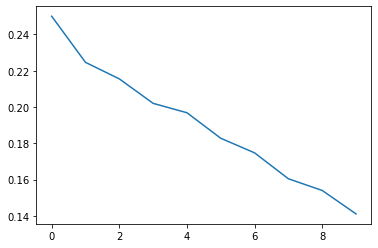

In [32]:
Pass_gen.train(X_train[:5000],y_train[:5000],100)

In [33]:
new_elem = torch.zeros(len(Pass_gen.elements),len(Pass_gen.elements[0]))
for i in range(len(Pass_gen.elements)):
    new_elem[i] = Pass_gen.elements[i]
new_elem

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [34]:
np.random.randint(1,100)

95

In [35]:
A = ['a','b','c','d','e']
B = [6,7,8,9,10]

print(shuf)
def mix(A,B):
    shuf = np.random.choice(len(A), len(A), replace=False)
    A = sorted(zip(shuf,A), key=lambda x:x[0])
    B = sorted(zip(shuf,B), key=lambda x:x[0])
    
    return list(zip(*A))[1], list(zip(*B))[1]
mix(A,B)
print(A,B)

NameError: name 'shuf' is not defined